# openFE Atom Mappers

## Build test data:
Initially start with some example data

In [26]:
import openfe
from openff.toolkit.topology import Molecule

# First, create some molecules to work with
benzene = Molecule.from_smiles('c1ccccc1')
benzene.name = 'benzene'
toluene = Molecule.from_smiles('c1ccccc1C')
toluene.name = "toluene"
phenol = Molecule.from_smiles('c1ccccc1O')
phenol.name = 'phenol'
catechol = Molecule.from_smiles('c1cccc(O)c1O')
catechol.name = 'catechol'
nitrobenzene = Molecule.from_smiles('C1=CC=C(C=C1)[N+](=O)[O-]')
nitrobenzene.name = 'nitrobenzene'
cyclohexane = Molecule.from_smiles('C1CCCCC1')
cyclohexane.name = 'cyclohexane'

mols = [benzene, toluene, phenol, catechol, nitrobenzene, cyclohexane]
[x.generate_conformers() for x in mols]
mols = list(map(lambda x: openfe.setup.SmallMoleculeComponent.from_openff(x, x.name), mols))

molA = mols[1]
molB = mols[3]

molA, molB

(SmallMoleculeComponent(name=toluene), SmallMoleculeComponent(name=catechol))

# Atom Mappers
## Lomap Mapper

Lomap-Score is 0.1392920235749422
Perses-Score is 0.9404761904761905


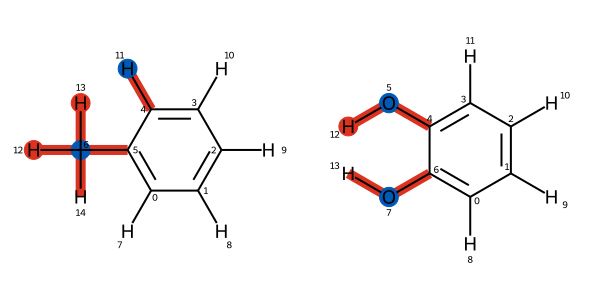

In [27]:
# LomapAtomMapper wraps the lomap.mcs.MCS object
lomap_mapper = openfe.setup.atom_mapping.LomapAtomMapper()


# mappers can return an *iterable* of mappings,
# for our case just grab the first with `next()`
lomap_mapping = next(lomap_mapper.suggest_mappings(molA, molB))

perses_scorer = openfe.setup.atom_mapping.perses_scorers.default_perses_scorer
lomap_scorer = openfe.setup.atom_mapping.lomap_scorers.default_lomap_score
print(f"Lomap-Score is {lomap_scorer(lomap_mapping)}")
print(f"Perses-Score is {perses_scorer(lomap_mapping)}")

lomap_mapping

In [28]:
vars(lomap_mapping)

{'molA': SmallMoleculeComponent(name=toluene),
 'molB': SmallMoleculeComponent(name=catechol),
 'molA_to_molB': {0: 0,
  1: 1,
  2: 2,
  3: 3,
  4: 4,
  5: 6,
  6: 7,
  7: 8,
  8: 9,
  9: 10,
  10: 11,
  11: 5,
  14: 13},
 '_annotations': {}}

## Perses Mapper

Lomap-Score is 0.1392920235749422
Perses-Score is 0.8611111111111112


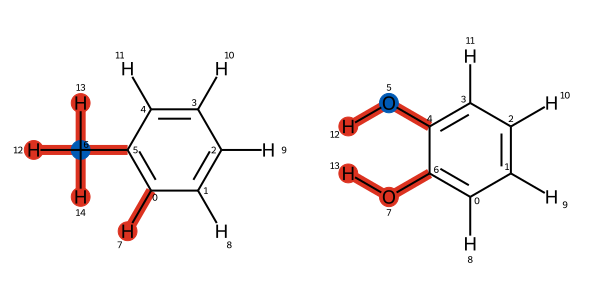

In [29]:
# LomapAtomMapper wraps the lomap.mcs.MCS object
perses_mapper = openfe.setup.atom_mapping.PersesAtomMapper()
#perses_scorer = openfe.setup.PersesScorer

# mappers can return an *iterable* of mappings,
# for our case just grab the first with `next()`
perses_mapping = next(perses_mapper.suggest_mappings(molA, molB))

perses_scorer = openfe.setup.atom_mapping.perses_scorers.default_perses_scorer
lomap_scorer = openfe.setup.atom_mapping.lomap_scorers.default_lomap_score
print(f"Lomap-Score is {lomap_scorer(perses_mapping)}")
print(f"Perses-Score is {perses_scorer(perses_mapping)}")

perses_mapping

# Use of Atom Mappers as iterables

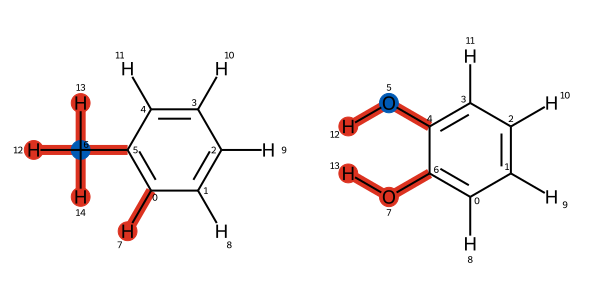

Lomap-Score is 0.1392920235749422
Perses-Score is 1.0428364065427083e-06


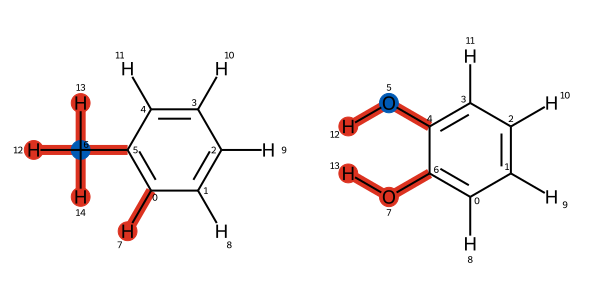

Lomap-Score is 0.1392920235749422
Perses-Score is 1.0428364065427083e-06


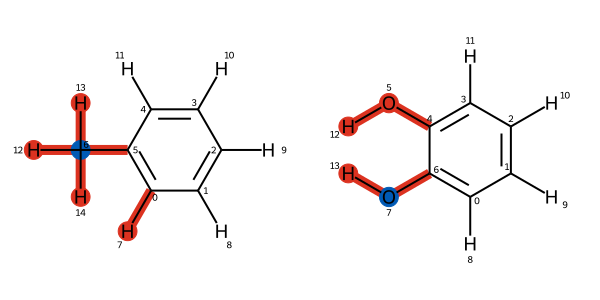

Lomap-Score is 0.1392920235749422
Perses-Score is 2.8732963870424917


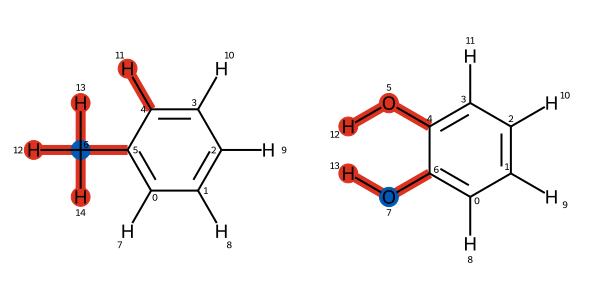

Lomap-Score is 0.1392920235749422
Perses-Score is 6.873296387042492


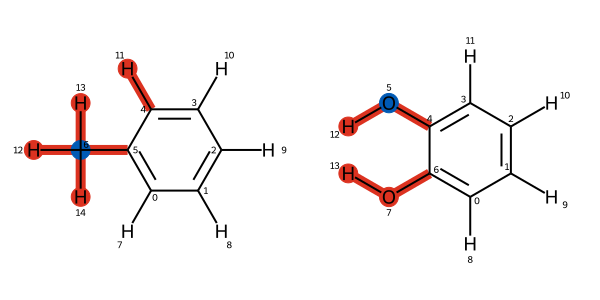

Lomap-Score is 0.1392920235749422
Perses-Score is 6.953878684401328e-07


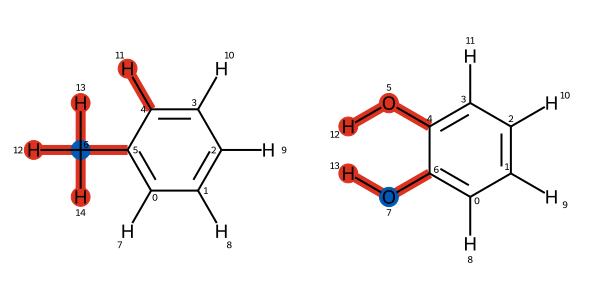

Lomap-Score is 0.1392920235749422
Perses-Score is 6.873296387042492


In [31]:
#Get multiple mappings
from IPython.display import display

perses_scorer = openfe.setup.atom_mapping.perses_scorers.default_perses_scorer
lomap_scorer = openfe.setup.atom_mapping.lomap_scorers.default_lomap_score

for x in perses_mapper.suggest_mappings(molA, molB):
    display(x)

    print(f"Lomap-Score is {lomap_scorer(x)}")
    print(f"Perses-Score is {perses_scorer(x, use_positions=True, normalize=False)}")